In [33]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
train_df = pd.read_csv('data-v6/train/train.csv')
test_df = pd.read_csv('data-v6/test/test.csv')
valid_df = pd.read_csv('data-v6/valid/valid.csv')

# Combine train and valid datasets for training
train_df = pd.concat([train_df, valid_df])
train_df = train_df[train_df['pothole_area_mm2'] <= 100000000]
train_df = train_df.dropna()  
test_df = test_df.dropna()

total_train_df = pd.concat([train_df, test_df])

train_df.to_csv('train_features.csv', index=False)

In [34]:
X_train = train_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_train = train_df['Bags used ']
X_test = test_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_test = test_df['Bags used ']

In [35]:
# STACKING REGRESSION ENSEMBLE MODEL

base_learners = [
    ('lr', LinearRegression()),
    ('svr', SVR(kernel='rbf', C=0.1, epsilon=0.1)),
    ('knn', KNeighborsRegressor(n_neighbors=10, p=1)),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=5))
]

meta_learners = {
    'Linear Regression': LinearRegression(),
    'RidgeCV': RidgeCV(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500),
}

for name, meta_learner in meta_learners.items():
    # Build the stacking regressor
    stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
    
    # Fit the stacking regressor
    stacking_regressor.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = stacking_regressor.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Predict on test data
    y_test_pred = stacking_regressor.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"Meta-Learner: {name}")
    print(f"Training MSE: {train_mse:.4f}, R^2: {train_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}, R^2: {test_r2:.4f}")
    print("-" * 50)

Meta-Learner: Linear Regression
Training MSE: 0.7164, R^2: 0.3992
Test MSE: 2404435.2885, R^2: -262389.1397
--------------------------------------------------
Meta-Learner: RidgeCV
Training MSE: 0.6326, R^2: 0.4695
Test MSE: 952045.9796, R^2: -103893.4482
--------------------------------------------------
Meta-Learner: Random Forest
Training MSE: 0.7692, R^2: 0.3549
Test MSE: 11.9451, R^2: -0.3035
--------------------------------------------------
Meta-Learner: Gradient Boosting
Training MSE: 0.7826, R^2: 0.3437
Test MSE: 12.2585, R^2: -0.3377
--------------------------------------------------
Meta-Learner: MLP Regressor
Training MSE: 0.6954, R^2: 0.4168
Test MSE: 1866629.8105, R^2: -203699.7438
--------------------------------------------------


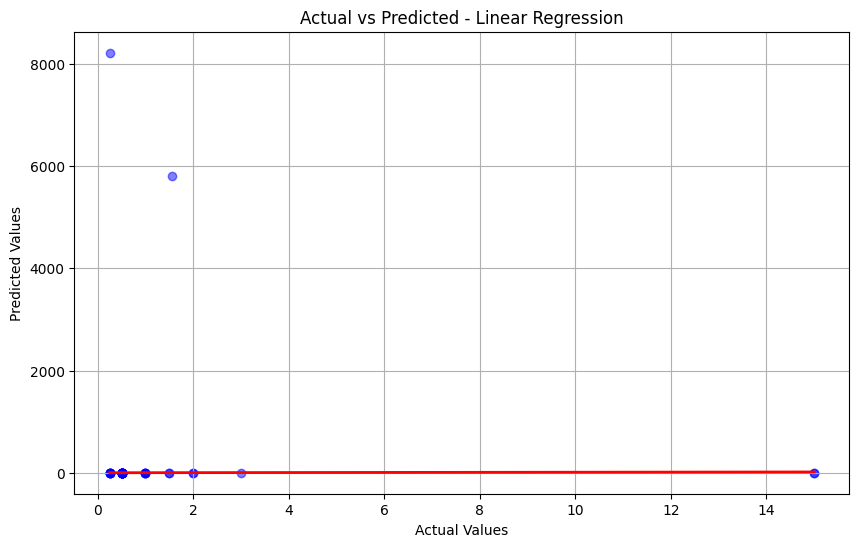

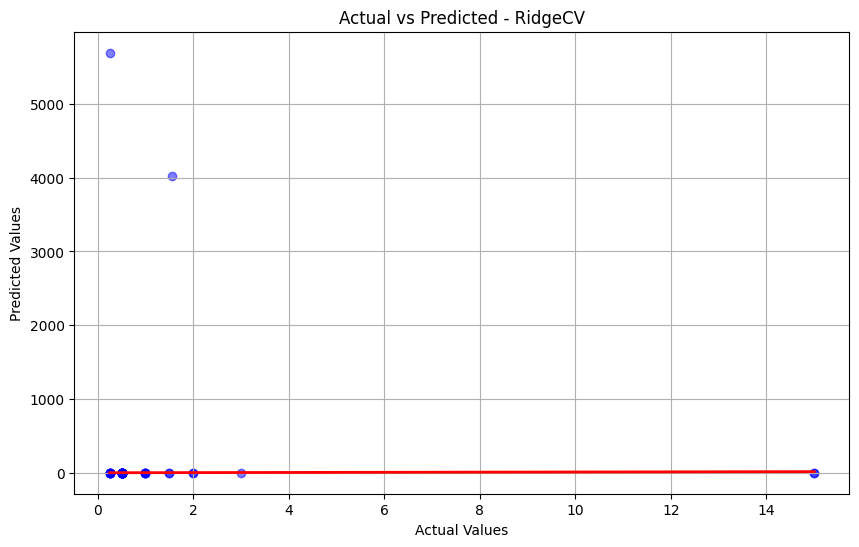

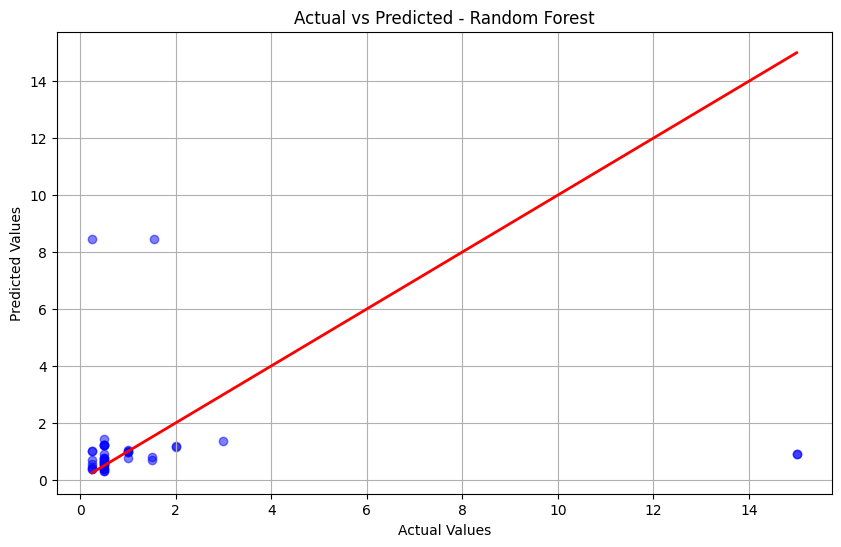

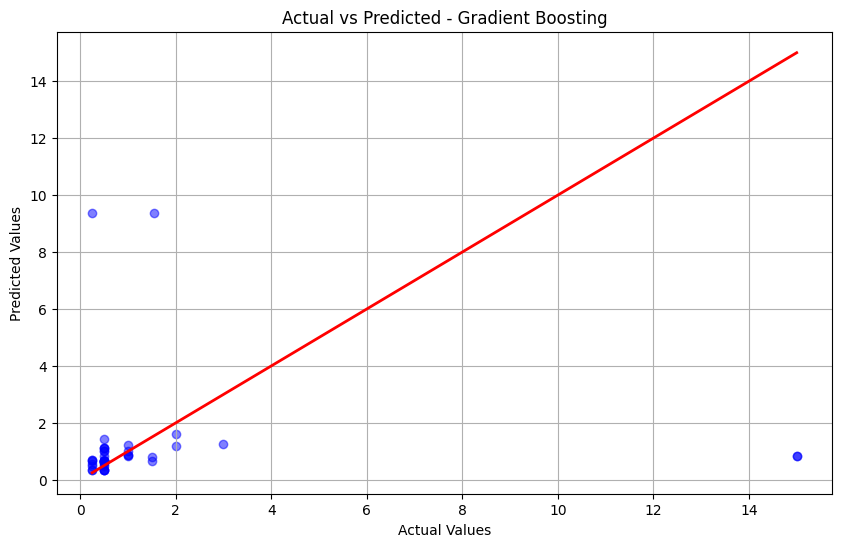

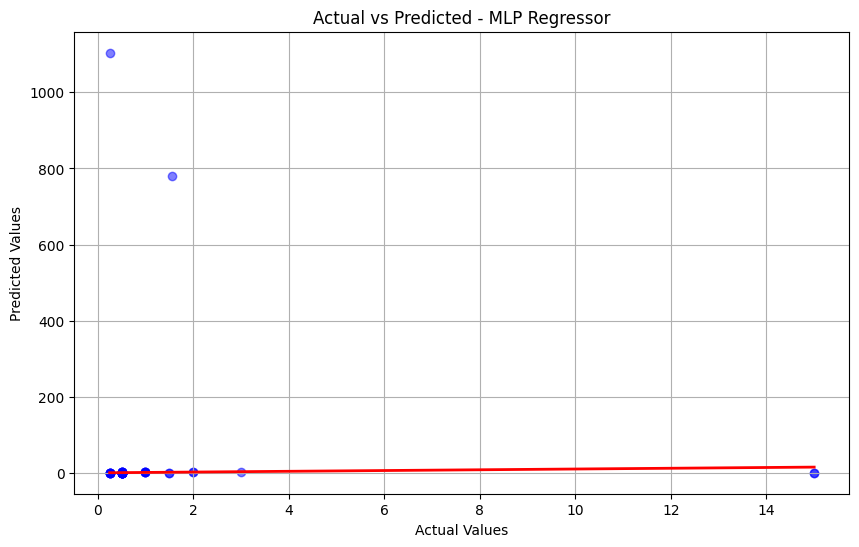

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define meta-learners to test
meta_learners = {
    'Linear Regression': LinearRegression(),
    'RidgeCV': RidgeCV(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500),
}

# Iterate over different meta-learners and evaluate performance
for name, meta_learner in meta_learners.items():
    # Build the stacking regressor
    stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
    
    # Fit the stacking regressor
    stacking_regressor.fit(X_train, y_train)
    
    # Predict on test data
    y_test_pred = stacking_regressor.predict(X_test)
    
    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Line of perfect prediction
    plt.title(f"Actual vs Predicted - {name}")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()


In [16]:
import pandas as pd

# Assuming `stacking_regressor` is the trained model with MLPRegressor as the meta-learner
# Load the new dataset
their_test_df = pd.read_csv('their_test.csv')

# Preprocess the new data if necessary
# Ensure the feature columns in 'their_test.csv' match those used during training
# X_their_test = their_test_df.drop(columns=['pothole_id'])  # Drop the 'Pothole number' column if it exists

# Make predictions
predictions = stacking_regressor.predict(their_test_df)

# Create a DataFrame with 'Pothole number' and 'Bags used'
results_df = pd.DataFrame({
    'Pothole number': their_test_df['pothole_id'],  # Assuming 'Pothole number' is a column in their_test_df
    'Bags used': predictions
})

# Write the results to a .csv file
results_df.to_csv('their_test_predictions.csv', index=False)

print("Predictions have been saved to 'their_test_predictions.csv'")


Predictions have been saved to 'their_test_predictions.csv'


In [18]:
# VOTING REGRESSION

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
train_df = pd.read_csv('data-v6/train/train.csv')
test_df = pd.read_csv('data-v6/test/test.csv')
valid_df = pd.read_csv('data-v6/valid/valid.csv')

# Combine train and valid datasets for training
train_df = pd.concat([train_df, valid_df])
train_df = train_df[train_df['pothole_area_mm2'] <= 10000000]
train_df = train_df.dropna()  
test_df = test_df.dropna()

# Split features and target variable
X_train = train_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_train = train_df['Bags used ']
X_test = test_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_test = test_df['Bags used ']

# Define individual regressors
regressors = [
    ('lr', LinearRegression()),
    ('svr', SVR(kernel='rbf', C=0.1, epsilon=0.1)),
    ('knn', KNeighborsRegressor(n_neighbors=10, p=1)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=10)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)),
]

# Build the voting regressor
voting_regressor = VotingRegressor(estimators=regressors)

# Fit the voting regressor
voting_regressor.fit(X_train, y_train)

# Predict on training data
y_train_pred = voting_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Predict on test data
y_test_pred = voting_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("Voting Regressor Results")
print(f"Training MSE: {train_mse:.4f}, R^2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, R^2: {test_r2:.4f}")
print("-" * 50)


Voting Regressor Results
Training MSE: 0.5404, R^2: 0.5464
Test MSE: 9.3805, R^2: -0.0237
--------------------------------------------------


In [20]:
print(train_df.head())

   pothole_id  pothole_area_mm2  Bags used 
0        1000     233878.745645       14.25
1        1002     245839.705882        4.00
2        1003      80540.738034        1.00
3        1008      41509.552145        0.50
4        1009       4370.874704        0.25


In [37]:
# STACKING REGRESSOR WITH OUTLIER 
# STACKING REGRESSION ENSEMBLE MODEL

# Load the data
train_df = pd.read_csv('data-v6/train/train.csv')
test_df = pd.read_csv('data-v6/test/test.csv')
valid_df = pd.read_csv('data-v6/valid/valid.csv')

# Combine train and valid datasets for training
train_df = pd.concat([train_df, valid_df])
#train_df = train_df[train_df['pothole_area_mm2'] <= 10000000]
train_df = train_df.dropna()  
test_df = test_df.dropna()

# Split features and target variable
X_train = train_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_train = train_df['Bags used ']
X_test = test_df.drop(columns=['Bags used '])  # Replace 'target' with your target column name
y_test = test_df['Bags used ']

base_learners = [
    ('lr', LinearRegression()),
    ('svr', SVR(kernel='rbf', C=0.1, epsilon=0.1)),
    ('knn', KNeighborsRegressor(n_neighbors=10, p=1)),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=5))
]

meta_learners = {
    'Linear Regression': LinearRegression(),
    'RidgeCV': RidgeCV(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500),
}

for name, meta_learner in meta_learners.items():
    # Build the stacking regressor
    stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
    
    # Fit the stacking regressor
    stacking_regressor.fit(X_train, y_train)
    
    # Predict on training data
    y_train_pred = stacking_regressor.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Predict on test data
    y_test_pred = stacking_regressor.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"Meta-Learner: {name}")
    print(f"Training MSE: {train_mse:.4f}, R^2: {train_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}, R^2: {test_r2:.4f}")
    print("-" * 50)

Meta-Learner: Linear Regression
Training MSE: 0.5300, R^2: 0.5552
Test MSE: 10.0315, R^2: -0.0947
--------------------------------------------------
Meta-Learner: RidgeCV
Training MSE: 0.5754, R^2: 0.5171
Test MSE: 9.9840, R^2: -0.0895
--------------------------------------------------
Meta-Learner: Random Forest
Training MSE: 0.7690, R^2: 0.3546
Test MSE: 10.5596, R^2: -0.1523
--------------------------------------------------
Meta-Learner: Gradient Boosting
Training MSE: 0.9725, R^2: 0.1838
Test MSE: 11.0622, R^2: -0.2072
--------------------------------------------------
Meta-Learner: MLP Regressor
Training MSE: 0.5271, R^2: 0.5576
Test MSE: 10.4337, R^2: -0.1386
--------------------------------------------------


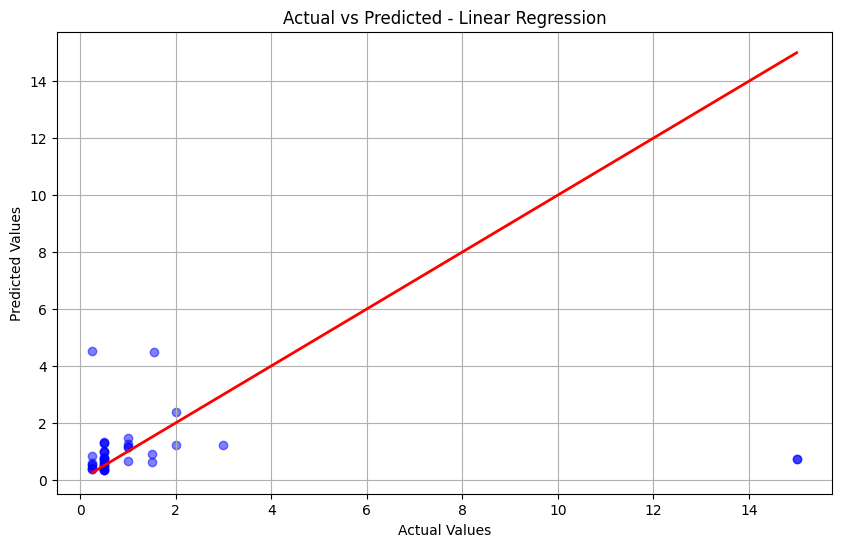

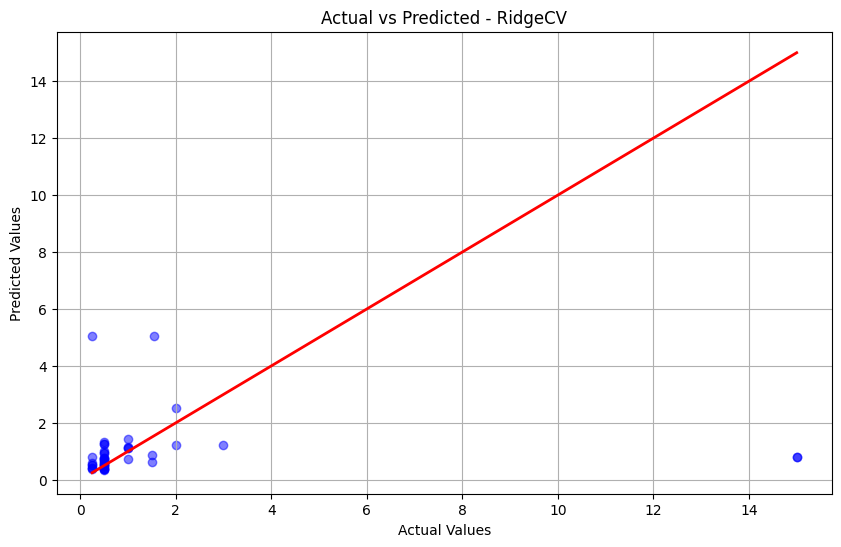

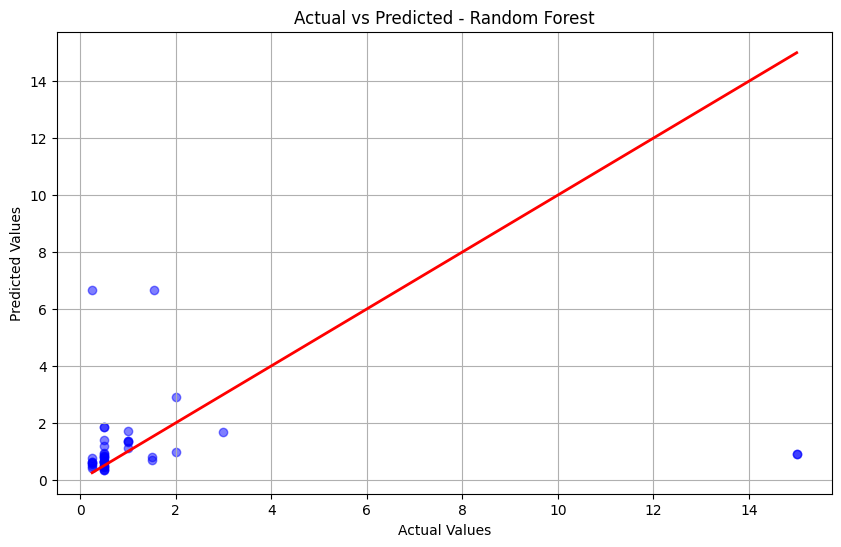

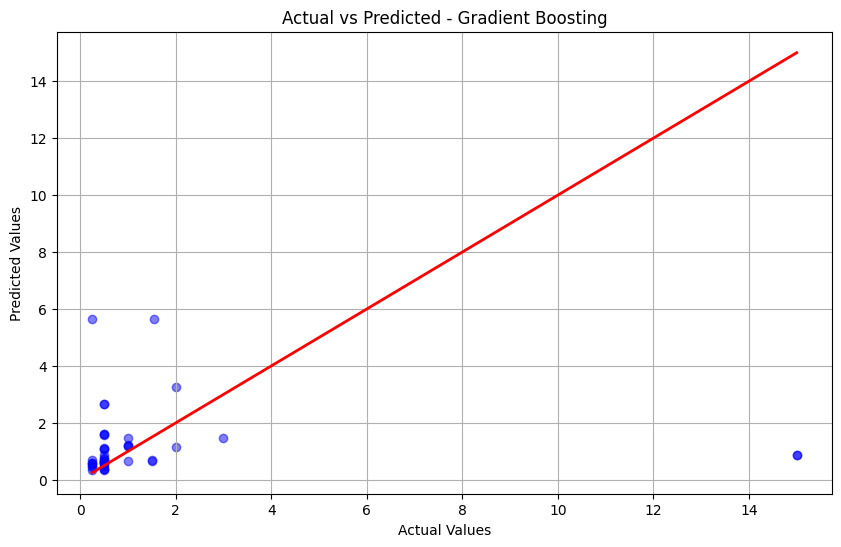

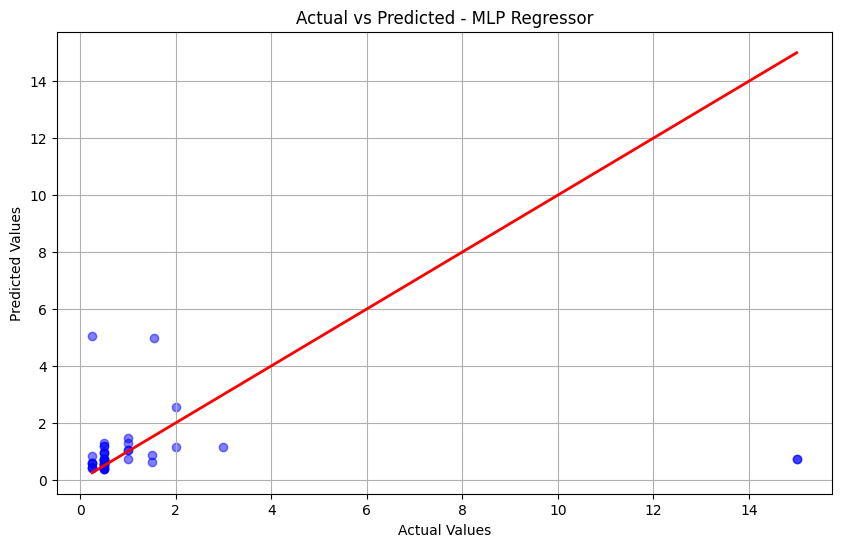

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define meta-learners to test
meta_learners = {
    'Linear Regression': LinearRegression(),
    'RidgeCV': RidgeCV(),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=500),
}

# Iterate over different meta-learners and evaluate performance
for name, meta_learner in meta_learners.items():
    # Build the stacking regressor
    stacking_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)
    
    # Fit the stacking regressor
    stacking_regressor.fit(X_train, y_train)
    
    # Predict on test data
    y_test_pred = stacking_regressor.predict(X_test)
    
    # Plot the predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Line of perfect prediction
    plt.title(f"Actual vs Predicted - {name}")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.show()


In [39]:
print(train_df['Bags used '].value_counts())

Bags used 
0.50     302
1.00     173
0.25     127
1.50      61
2.00      42
2.50      15
3.00      10
4.00       4
1.05       3
0.55       3
8.00       3
2.05       1
12.00      1
7.00       1
5.00       1
6.00       1
14.25      1
5.50       1
3.05       1
3.10       1
1.55       1
3.50       1
6.50       1
Name: count, dtype: int64
